In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
confirmed = pd.read_csv("covid_19_confirmed_v1.csv")
deaths = pd.read_csv("covid_19_deaths_v1.csv", header=1)
recovered = pd.read_csv("covid_19_recovered_v1.csv", header=1)

In [3]:
print("Confirmed Cases")
print(confirmed.head())

print("\nDeaths")
print(deaths.head())

print("\nRecovered")
print(recovered.head())

Confirmed Cases
  Province/State Country/Region       Lat       Long  1/22/20  1/23/20  \
0            NaN    Afghanistan  33.93911  67.709953        0        0   
1            NaN        Albania  41.15330  20.168300        0        0   
2            NaN        Algeria  28.03390   1.659600        0        0   
3            NaN        Andorra  42.50630   1.521800        0        0   
4            NaN         Angola -11.20270  17.873900        0        0   

   1/24/20  1/25/20  1/26/20  1/27/20  ...  5/20/21  5/21/21  5/22/21  \
0        0        0        0        0  ...    64575    65080    65486   
1        0        0        0        0  ...   132118   132153   132176   
2        0        0        0        0  ...   126156   126434   126651   
3        0        0        0        0  ...    13569    13569    13569   
4        0        0        0        0  ...    31661    31909    32149   

   5/23/21  5/24/21  5/25/21  5/26/21  5/27/21  5/28/21  5/29/21  
0    65728    66275    66903    6

In [4]:
confirmed.info()
deaths.info()
recovered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276 entries, 0 to 275
Columns: 498 entries, Province/State to 5/29/21
dtypes: float64(2), int64(494), object(2)
memory usage: 1.0+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276 entries, 0 to 275
Columns: 498 entries, Province/State to 5/29/21
dtypes: float64(3), int64(493), object(2)
memory usage: 1.0+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261 entries, 0 to 260
Columns: 498 entries, Province/State to 5/29/21
dtypes: float64(3), int64(493), object(2)
memory usage: 1015.6+ KB


In [5]:
#Missing Value Checkpoint

print("Missing values in confirmed:")
print(confirmed.isnull().sum())

print("\nMissing values in deaths")
print(deaths.isnull().sum())

print("\nMissing values in recovered")
print(recovered.isnull().sum())

Missing values in confirmed:
Province/State    190
Country/Region      0
Lat                 2
Long                2
1/22/20             0
                 ... 
5/25/21             0
5/26/21             0
5/27/21             0
5/28/21             0
5/29/21             0
Length: 498, dtype: int64

Missing values in deaths
Province/State    190
Country/Region      0
Lat                 2
Long                2
1/22/20             0
                 ... 
5/25/21             0
5/26/21             0
5/27/21             0
5/28/21             0
5/29/21             0
Length: 498, dtype: int64

Missing values in recovered
Province/State    191
Country/Region      0
Lat                 1
Long                1
1/22/20             0
                 ... 
5/25/21             0
5/26/21             0
5/27/21             0
5/28/21             0
5/29/21             0
Length: 498, dtype: int64


In [6]:
confirmed['Province/State'] = confirmed['Province/State'].fillna('All province')
deaths['Province/State'] = deaths['Province/State'].fillna('All province')
recovered['Province/State'] = recovered['Province/State'].fillna('All province')

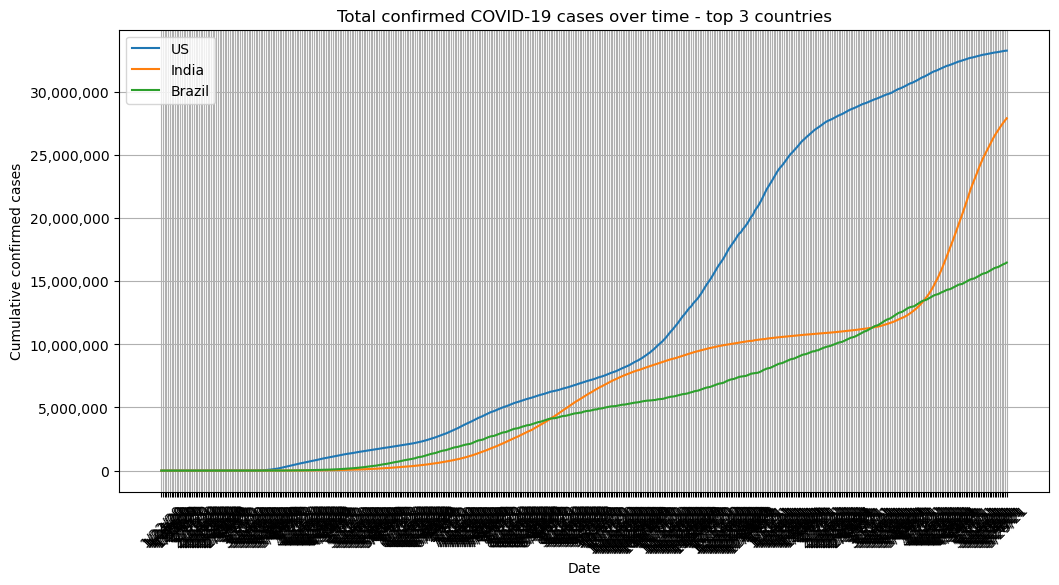

In [7]:
# Total Cases Over time - Tope 3 Countries
import matplotlib.ticker as ticker
confirmed.iloc[:, 4:] = confirmed.iloc[:, 4:].apply(pd.to_numeric, errors='coerce')
country_grouped = confirmed.groupby('Country/Region').sum(numeric_only=True)

top3_countries = country_grouped.iloc[:, -1].sort_values(ascending=False).head(3).index

plt.figure(figsize=(12, 6))
for country in top3_countries:
    country_data = confirmed[confirmed['Country/Region'] == country].iloc[:,4:].sum()
    plt.plot(country_data.index, country_data.values, label=country)

plt.title("Total confirmed COVID-19 cases over time - top 3 countries")
plt.xlabel("Date")
plt.ylabel("Cumulative confirmed cases")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{int(x):,}"))

plt.show()

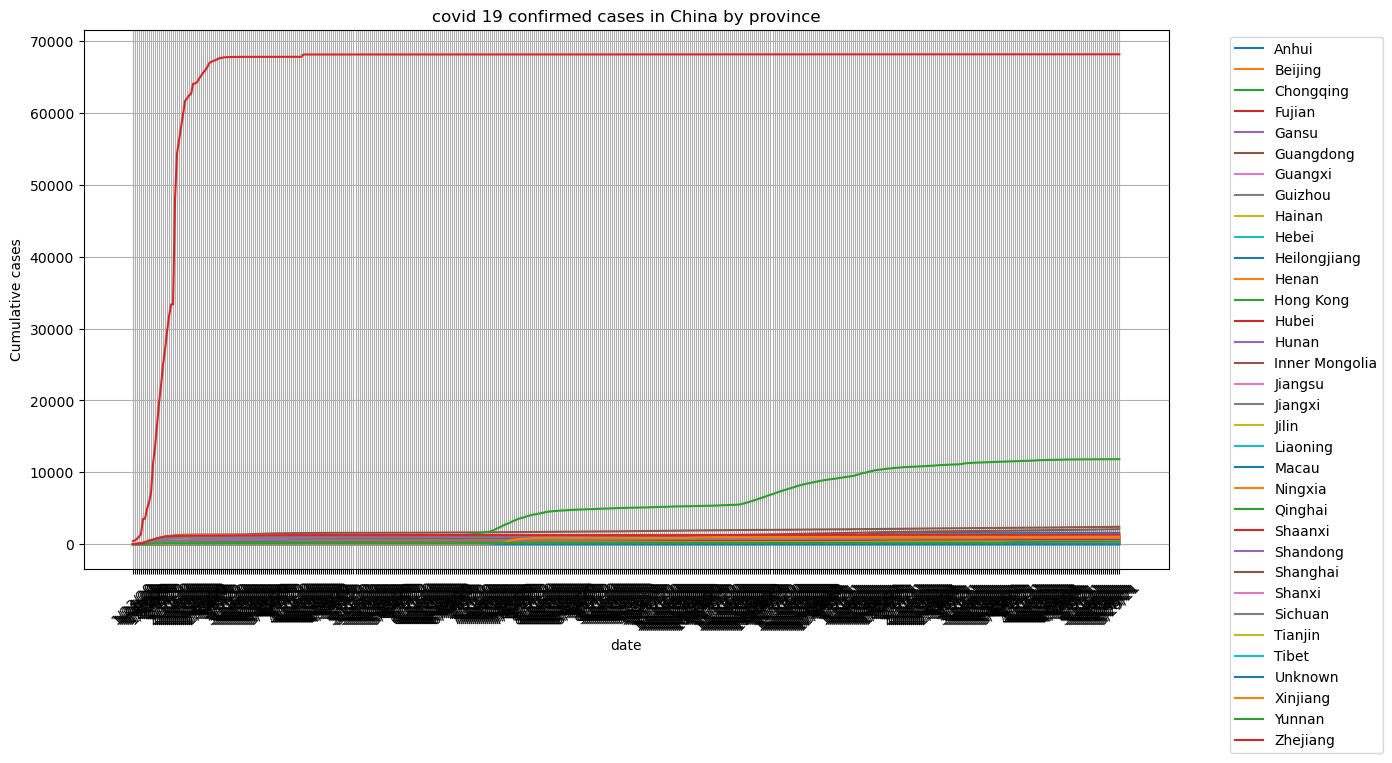

In [8]:
china_data = confirmed[confirmed['Country/Region'] == 'China']
china_province_data = china_data.set_index('Province/State').iloc[:, 4:].T

plt.figure(figsize=(14, 7))
for province in china_province_data.columns:
    plt.plot(china_province_data.index, china_province_data[province], label=province)

plt.title("covid 19 confirmed cases in China by province")
plt.xlabel("date")
plt.ylabel("Cumulative cases")
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

In [9]:
meta_cols = ["Province/State", "Country/Region", "Lat", "Long"]
date_cols = [c for c in confirmed.columns if c not in meta_cols]

In [10]:
confirmed_by_country = (
    confirmed
    .drop(columns=["Lat", "Long"], errors="ignore")
    .groupby("Country/Region", as_index=True)[date_cols]
    .sum()
)

In [11]:
daily_by_country = confirmed_by_country.diff(axis=1)
daily_by_country.iloc[:, 0] = 0
daily_by_country = daily_by_country.clip(lower=0)

In [12]:
# 7 day moving average
daily7_by_country = daily_by_country.rolling(window=7, axis=1, min_periods=1).mean()

C:\Users\mahip\AppData\Local\Temp\ipykernel_21100\1188114054.py:2: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  daily7_by_country = daily_by_country.rolling(window=7, axis=1, min_periods=1).mean()


In [13]:
# find peak surge days for slected countries
focus_countries = ["Germany", "France", "Italy", "India"]

peak_report = {}

for country in focus_countries:
    series = daily_by_country.loc[country]
    peak_value = int(series.max())
    peak_date = series.idxmax()
    peak_report[country] = {"peak_daily_new": peak_value, "peak_date": peak_date}

print("Peak surge report (daily new cases):")
for k, v in peak_report.items():
    print(f" - {k}: {v['peak_daily_new']} on {v['peak_date']}")

Peak surge report (daily new cases):
 - Germany: 49044 on 12/30/20
 - France: 117900 on 4/11/21
 - Italy: 40902 on 11/13/20
 - India: 414188 on 5/6/21


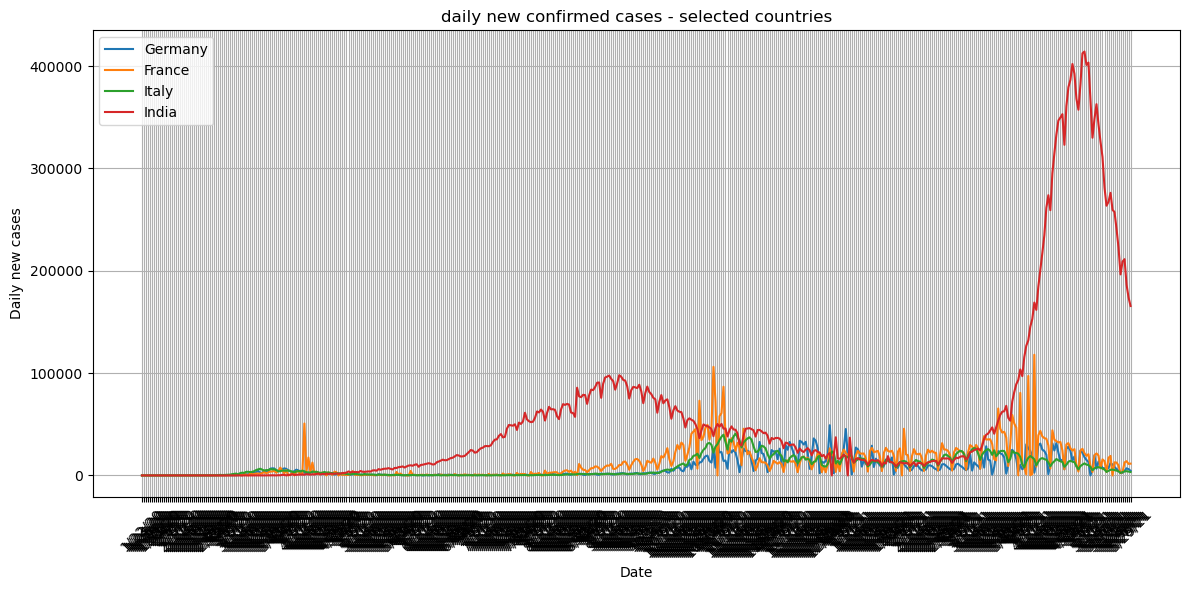

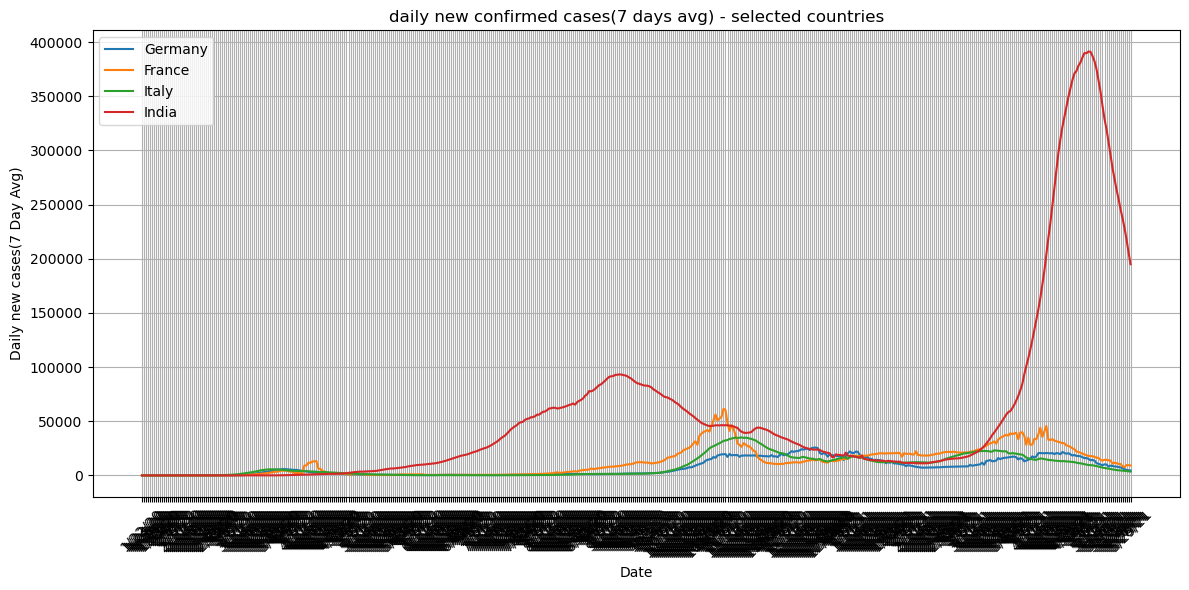

In [15]:
#we plot two charts
# 1. raw daily new cases, 2. 7 day smooth daily new
plt.figure(figsize=(12,6))
for country in focus_countries:
    series = daily_by_country.loc[country]
    plt.plot(series.index, series.values, label=country)

plt.title("daily new confirmed cases - selected countries")
plt.xlabel("Date")
plt.ylabel("Daily new cases")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#2. 7 day smooth daily new
plt.figure(figsize=(12,6))
for country in focus_countries:
    series = daily7_by_country.loc[country]
    plt.plot(series.index, series.values, label=country)
plt.title("daily new confirmed cases(7 days avg) - selected countries")
plt.xlabel("Date")
plt.ylabel("Daily new cases(7 Day Avg)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [16]:
# monthly totals per country

date_index = pd.to_datetime(confirmed_by_country.columns)

C:\Users\mahip\AppData\Local\Temp\ipykernel_21100\4254992757.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  date_index = pd.to_datetime(confirmed_by_country.columns)


In [17]:
month_labels = pd.PeriodIndex(date_index, freq="M").astype(str)

monthly_by_country = daily_by_country.groupby(by=month_labels, axis=1).sum()

print("Monthly table shape:", monthly_by_country.shape)
print(monthly_by_country.iloc[:5, :5])

Monthly table shape: (193, 17)
                2020-01  2020-02  2020-03  2020-04  2020-05
Country/Region                                             
Afghanistan         0.0      1.0    174.0   1952.0  13081.0
Albania             0.0      0.0    243.0    530.0    364.0
Algeria             0.0      1.0    715.0   3290.0   5388.0
Andorra             0.0      0.0    376.0    369.0     19.0
Angola              0.0      0.0      7.0     20.0     59.0


C:\Users\mahip\AppData\Local\Temp\ipykernel_21100\3727999875.py:3: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  monthly_by_country = daily_by_country.groupby(by=month_labels, axis=1).sum()


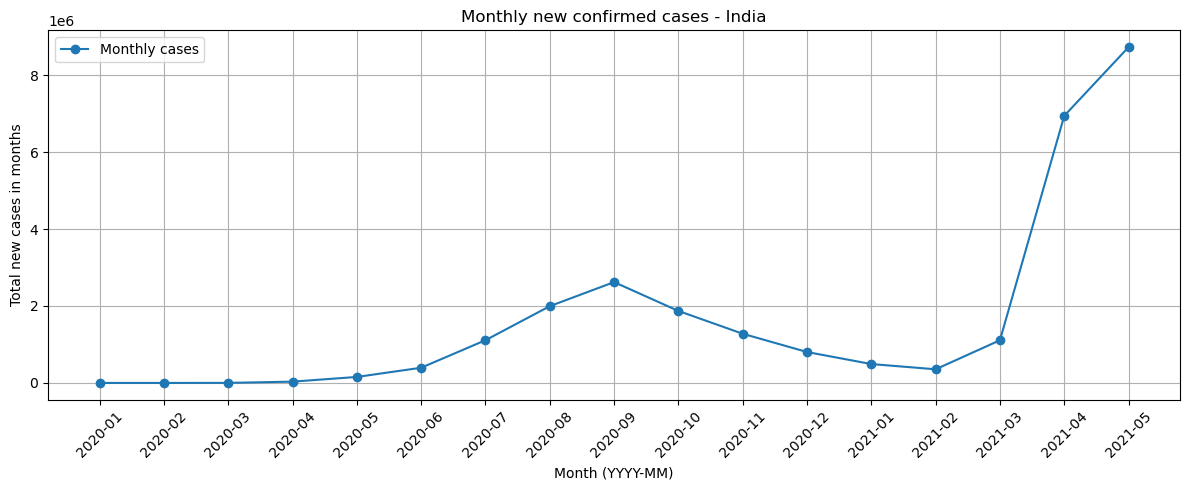

In [21]:
country_to_plot = "India"
series_monthly = monthly_by_country.loc[country_to_plot]

plt.figure(figsize=(12,5))
plt.plot(series_monthly.index, series_monthly.values, marker='o', label="Monthly cases")
plt.title(f"Monthly new confirmed cases - {country_to_plot}")
plt.xlabel("Month (YYYY-MM)")
plt.ylabel("Total new cases in months")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [22]:
# top N countries by latest cumulative and there daily profiles
latest_date = confirmed_by_country.columns[-1]
topN = 5
topN_countires = confirmed_by_country[latest_date].nlargest(topN).index.tolist()
print(f"Top {topN} countries on {latest_date}:")
print(topN_countires)

Top 5 countries on 5/29/21:
['US', 'India', 'Brazil', 'France', 'Turkey']


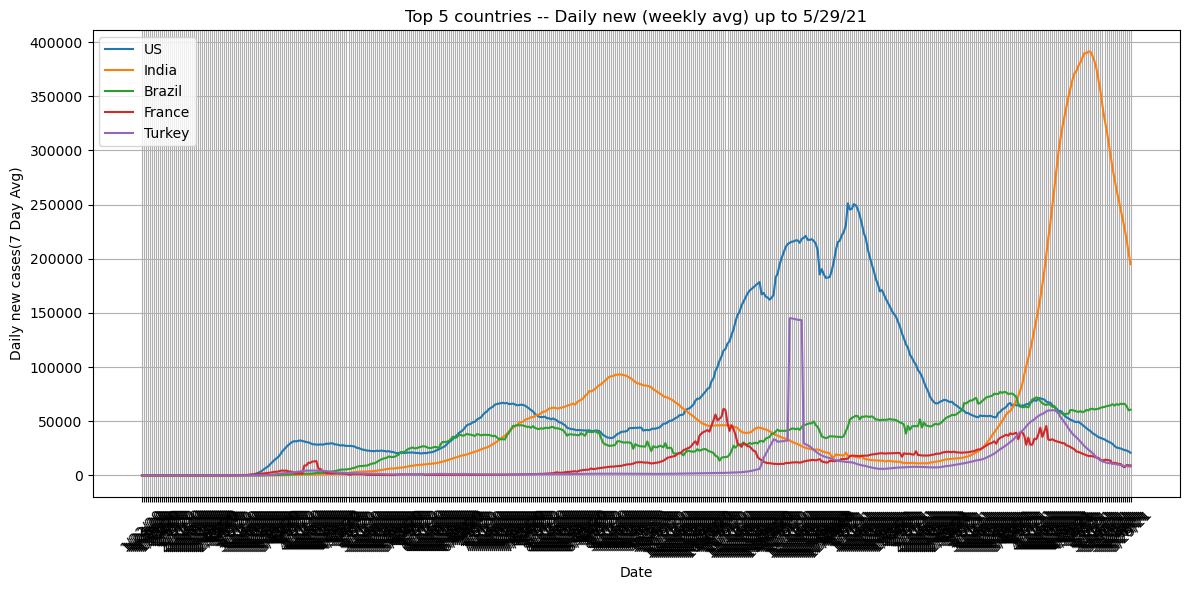

In [23]:
plt.figure(figsize=(12,6))
for country in topN_countires:
    series = daily7_by_country.loc[country]
    plt.plot(series.index, series.values, label=country)
plt.title(f"Top {topN} countries -- Daily new (weekly avg) up to {latest_date}")
plt.xlabel("Date")
plt.ylabel("Daily new cases(7 Day Avg)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()